## Calculate the SVF from Ground DSM using PyCUDA
This script will use the shadow casting algorithm to calculate the sky view factors. The method based on the Ray-tracing has been implemented. Let's compare the dfficiency of these methods later. 

First version Dec 22, 2020, by Xiaojiang Li, Temple University

Last modified Dec 30, 2020

## Calculate the svf based on the ground-dsm using the shadow casting method

In [1]:
import os, os.path
import rasterio as rio
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
# demroot = '/drive2/thermal-env/data/philadelphia/tiles1000'


# for file in os.listdir(demroot):
#     demfile = os.path.join(demroot, file)
#     lu_dataset = rio.open(demfile)
    
#     lu_bounds = lu_dataset.bounds
#     lu_img = lu_dataset.read(1)
#     print('The lu_bounds is:', lu_bounds)
#     break

In [4]:
# fig = plt.figure(figsize=(10,10))
# plt.imshow(lu_img)
# plt.show()

In [5]:
# save the geo-referenced raster data
def saverasternd(gdal_data, filename, raster):
    rows = gdal_data.RasterYSize
    cols = gdal_data.RasterXSize
    
    outDs = gdal.GetDriverByName("GTiff").Create(filename, cols, rows, int(1), GDT_Float32)
    outBand = outDs.GetRasterBand(1)
    
    # write the data
    outBand.WriteArray(raster, 0, 0)
    # flush data to disk, set the NoData value and calculate stats
    outBand.FlushCache()
    outBand.SetNoDataValue(-9999)
    
    # georeference the image and set the projection
    outDs.SetGeoTransform(gdal_data.GetGeoTransform())
    outDs.SetProjection(gdal_data.GetProjection())
    

## Using GPU to accelerate the SVF computing

In [6]:
from pycuda.compiler import SourceModule
import pycuda
from pycuda import gpuarray
from pycuda import compiler
import pycuda.driver as cuda
import pycuda.autoinit             # PyCuda autoinit
import pycuda.driver as cuda       # PyCuda In, Out helpers
import matplotlib.pyplot as plot   # Library to plot
import matplotlib.cm as colormap   # Library to plot
import numpy                       # Fast math library
import time
import numpy as np                     # numeric python lib
import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour
import scipy.ndimage as ndi            # to determine shape centrality
# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (8, 8)      # setting default size of plots

from osgeo import gdal
from osgeo.gdalconst import *
import os, os.path
import numpy as np
import rasterio
import time
gdal.UseExceptions() #so it doesn't print to screen everytime point is outside grid


print("%d device(s) found." % cuda.Device.count())           
for ordinal in range(cuda.Device.count()):
    dev = cuda.Device(ordinal)
    print ("Device #%d: %s" % (ordinal, dev.name()))
print (cuda)


1 device(s) found.
Device #0: NVIDIA GeForce GTX 1050
<module 'pycuda.driver' from 'C:\\Users\\sasha\\anaconda3\\envs\\climategpu\\lib\\site-packages\\pycuda\\driver.py'>


In [7]:
 #Kernel text
kernel = """
#include <math.h>

#define _X  ( threadIdx.x + blockIdx.x * blockDim.x )
#define _Y  ( threadIdx.y + blockIdx.y * blockDim.y )
#define _WIDTH  ( blockDim.x * gridDim.x )
#define _HEIGHT ( blockDim.y * gridDim.y  )
#define _XM(x)  ( (x + _WIDTH) % _WIDTH )
#define _YM(y)  ( (y + _HEIGHT) % _HEIGHT )
#define _INDEX(x,y)  ( _XM(x)  + _YM(y) * _WIDTH )
#define PI 3.1415926


//https://github.com/AlainPaillou/PyCuda_Denoise_Filters/blob/master/PyCuda_KNN_Denoise_Mono.py
// note: float is correspond to np.float32
__global__ void shadowCast(float * lattice_out, float * lattice, float azimuth, float altitude) //int w, int h
{
    #define NLM_BLOCK_RADIUS    3
    
    int imageW = 1320;
    int imageH = 1320;
    
    const long int   ix = blockDim.x * blockIdx.x + threadIdx.x;
    const long int   iy = blockDim.y * blockIdx.y + threadIdx.y;
    const float  x = (float)ix  + 1.0f;
    const float  y = (float)iy  + 1.0f;
    const float limxmin = NLM_BLOCK_RADIUS + 2;
    const float limxmax = imageW - NLM_BLOCK_RADIUS - 2;
    const float limymin = NLM_BLOCK_RADIUS + 2;
    const float limymax = imageH - NLM_BLOCK_RADIUS - 2;
    
    long int index4;    
    
    if(ix>limxmin && ix<limxmax && iy>limymin && iy<limymax)
    {
        
        //Result accumulator
        float clr00 = 0.0;
        float clrIJ = 0.0;
        
        //Center of the KNN window
        index4 = x + (y * imageW);
        
        // the current pixel
        clr00 = lattice[index4];
        
        
        int rangeDist = 200;
        float betaMax = 0;
        float altitude_degree = PI*altitude/180.0;
        float theta;
        
        // convert the sun azimuth (clockwise zero at North) to theta (anticlockwise, zero at east)
        if (azimuth < 90 & azimuth > 0) {
            theta = PI*(90 - azimuth)/180.0;
        } else { //azimuth > 180 & azimuth<360
            theta = PI*(450 - azimuth)/180.0;
        }
        
        int flag = 0;
        for( float radius = 5; radius < rangeDist; radius = radius + 5)
        {   
            if (x + int(radius*cos(theta)) > limxmax | x + int(radius*cos(theta)) < limxmin | y - int(radius*sin(theta)) > limymax | y - int(radius*sin(theta)) < 0) 
            {
                break;
            }
            
            long int index2 = x + int(radius*cos(theta)) + (y - int(radius*sin(theta))) * imageW;
            clrIJ = lattice[index2];

            // building height information
            float buildH = clrIJ - clr00;
            
            float beta = atan(0.5*buildH/radius); //because the pixel resolution is 2ft, height is in ft
            
            if (betaMax > altitude_degree) 
            {
                //lattice_out[index4] = 1; //building is too high, shadow
                flag = 1;
                break;
            }
            
            if (betaMax < beta)
            {
                betaMax = beta;
            }
        }
        
        if (flag == 1) {
            lattice_out[index4] = 0; //building is too high, shadow
        } else {
            if (betaMax > altitude_degree) 
            {
                lattice_out[index4] = 0; //building is too high, shadow
            } else {
                lattice_out[index4] = 1; // not shadow
            }
        }
    }
}


__device__ void annulus_weight(float altitude, float aziinterval, float *weight) {
    float n = 90.0;
    float steprad = (360./aziinterval) * PI/180.0;
    float annulus = 91.0 - altitude;
    float w = 1.0/(2.0*PI) * sin(PI / (2.0*n)) * sin((PI * (2.0 * annulus - 1.0)) / (2.0 * n));
    *weight = steprad * w;
}



__global__ void svf_shadowcasting_2018a_gpu(float * svf_Latt, float * dsm_Latt, 
                                            float *iazimuth_Latt, float scale, 
                                            int imageW, int imageH)
{
    #define NLM_BLOCK_RADIUS    3
    
    //int imageW = 2000; //1320
    //int imageH = 2000; //1320

    const long int ix = blockDim.x * blockIdx.x + threadIdx.x;
    const long int iy = blockDim.y * blockIdx.y + threadIdx.y;
    
    const float x = min((float)ix + 1, (float)(imageW - 1));
    const float y = min((float)iy + 1, (float)(imageH - 1));
        
    const float limxmin = -1;             //NLM_BLOCK_RADIUS + 2;
    const float limxmax = imageW;  //-1      // - NLM_BLOCK_RADIUS - 2;
    const float limymin = -1;             //NLM_BLOCK_RADIUS + 2;
    const float limymax = imageH;  // -1      // - NLM_BLOCK_RADIUS - 2;
    
    
    long int index4;
    
    
    if(ix>limxmin && ix<limxmax && iy>limymin && iy<limymax)
    {
        
        //The index pixel
        index4 = x + (y * imageW);
        
        float iangle[] = {6, 18, 30, 42, 54, 66, 78, 90};
        float aziinterval[] = {30, 30, 24, 24, 18, 12, 6, 1};
        float annulino[] = {0, 12, 24, 36, 48, 60, 72, 84, 90};
        
        float svf = 0;
        int idx = 0;
        for (int i = 0; i<8; i++) {
            for (int j=0; j < aziinterval[i]; j++) {
                float altitude = iangle[i];
                float azimuth;
                
                if (idx - 1 < 0) {
                    azimuth = iazimuth_Latt[144];
                } else {
                    azimuth = iazimuth_Latt[idx - 1];
                }
                
                
                float altitude_degree = PI*altitude/180.0;
                float theta;
                
                // convert the sun azimuth (clockwise zero at North) to theta (anticlockwise, zero at east)
                if (azimuth < 90 & azimuth > 0) {
                    theta = PI*(90 - azimuth)/180.0;
                } else { //azimuth > 180 & azimuth<360
                    theta = PI*(450 - azimuth)/180.0;
                }
                
                
                // the search radius for the SVF computing
                int rangeDist = 400;
                
                float sh = 0;
                float f = dsm_Latt[index4];
                
                float temp = 0;
                
                for( float radius = 0; radius < rangeDist; radius = radius + 1)
                {   
                    if (x + int(radius*cos(theta)) > limxmax | x + int(radius*cos(theta)) < limxmin | y - int(radius*sin(theta)) > limymax | y - int(radius*sin(theta)) < 0) 
                    {
                        break;
                    }
                    
                    temp = 0;
                    long int index2 = x + int(radius*cos(theta)) + (y - int(radius*sin(theta))) * imageW;
                    
                    // building height information
                    temp = dsm_Latt[index2] - radius*tan(altitude_degree)/scale;
                    
                    if (f < temp) {
                        f = temp;
                    }
                    
                }
                
                if (f == dsm_Latt[index4]) {
                    sh = 1;
                } else {
                    sh = 0;
                }
                
                float weight;
                for (int k = annulino[i] + 1; k < annulino[i + 1] + 1; k++){
                    annulus_weight(k, aziinterval[i], &weight);
                    weight *= sh;
                    svf += weight;
                }
                
                idx++;
            }
        }
        
        svf_Latt[index4] = svf;
    }
}


"""

#Compile and get kernel function
mod = SourceModule(kernel)
print (mod)


### A more GPU enabled implementation of the shadow casting

In [8]:
def svf_shadowcasting_2018a_gpu(mod, dsmimg, scale):    
    '''This is the shadow casting algorithm to calculate the sky view factor
    This version will implement all the process of shadow casting and the svf
    estimation
    
    Parameter:
        mod: the module of the SVF estimation kernel
        dsmimg: the numpy array of the digital surface model
    '''
    
    import numpy as np
    
    
    index = int(0)
    iazimuth = np.hstack(np.zeros((1, 145)))
    # ialtitude = np.zeros((1, 145))
    
    azistart = np.array([0, 4, 2, 5, 8, 0, 10, 0])
    
    skyvaultaziint = np.array([12, 12, 15, 15, 20, 30, 60, 360]) #azimuth
    skyvaultaltint = np.array([6, 18, 30, 42, 54, 66, 78, 90])   #altitude
    
    for j in range(0, 8):
        for k in range(0, int(360 / skyvaultaziint[j])):
            iazimuth[index] = k * skyvaultaziint[j] + azistart[j]
            if iazimuth[index] > 360.:
                iazimuth[index] = iazimuth[index] - 360.
            index = index + 1
    
    
    # the input numpy arrays
    iazimuth = np.array(iazimuth).astype(np.float32)
    dsmimg = np.array(dsmimg).astype(np.float32)
    
    # allocate memory on the device and transfer data to GPU 
    dsm_px = cuda.mem_alloc(dsmimg.nbytes)
    iazimuth_px = cuda.mem_alloc(iazimuth.nbytes)
    
    cuda.memcpy_htod(dsm_px, dsmimg)
    cuda.memcpy_htod(iazimuth_px, iazimuth)
    
    
    height,width = dsmimg.shape
    nb_pixels = height * width
    
    
    # Set blocks et Grid sizes
    nb_ThreadsX = 8
    nb_ThreadsY = 8
    nb_blocksX = (width // nb_ThreadsX) + 1
    nb_blocksY = (height // nb_ThreadsY) + 1
    #print("Test GPU ",nb_blocksX*nb_blocksY," Blocks ",nb_ThreadsX*nb_ThreadsY," Threads/Block")
    
    
    #### Ground View Factors ####  
    # create empty array for saving 
    svf_gpu = gpuarray.to_gpu(dsmimg)
    svf_Lattice_gpu = gpuarray.empty_like(svf_gpu) 
    
    
    #print('type of azimuth and altitude are:', type(azimuth), type(altitude))
    # the GPU function
    KNN_Mono_GPU = mod.get_function("svf_shadowcasting_2018a_gpu")
    KNN_Mono_GPU(svf_Lattice_gpu, \
                 dsm_px, \
                 iazimuth_px, \
                 np.float32(scale), \
                 np.int32(width), \
                 np.int32(height), \
                 block=(nb_ThreadsX, nb_ThreadsY, 1), \
                 grid=(nb_blocksX, nb_blocksY))
    
    
    svfPx = numpy.empty_like(dsmimg)
    svfPx = svf_Lattice_gpu.get()
    svfPx = np.float32(svfPx)
    
    return svfPx
    

In [9]:
#dsmfile = r'C:\Users\sasha\Downloads\B_split\B_0.TIF'
#dsmfile = r"C:\Users\sasha\OneDrive\Desktop\B_split_middle\Buildings_0.TIF"

#gdal_dsm = gdal.Open(dsmfile)
#dsm = gdal_dsm.ReadAsArray().astype(np.float32)#dsm
#geotransform = gdal_dsm.GetGeoTransform()
#scale = 1 / geotransform[1]

#t1 = time.time()
#svfres = svf_shadowcasting_2018a_gpu(mod, dsm, scale)
#print('The time consumption is:', time.time() - t1)


The time consumption is: 39.774879455566406


In [11]:
#root = r"C:\Users\sasha\Downloads\B_split_middle"
#outroot = r"C:\Users\sasha\Downloads\B_split_middle\Buildings_tile_SVF_2run"

#root = r'C:\Users\sasha\Downloads\new\T_split_expanded'
root = r"C:\Users\sasha\Downloads\new\B_split_middle_expanded"
outroot = r"C:\Users\sasha\Downloads\new\Buildings_exp_SVF"

totaltime=0

if not os.path.exists(outroot):
    os.mkdir(outroot)

for file in os.listdir(root):
    if file.lower().endswith(".tif"):  # Ensures case insensitivity
        filename = os.path.join(root, file)
        
        t0 = time.time()
    
        gdal_dsm = gdal.Open(filename)
        dsm = gdal_dsm.ReadAsArray().astype(np.float32)#dsm
        geotransform = gdal_dsm.GetGeoTransform()
        scale = 1 / geotransform[1]
    
    
        ## calculate the svf
        svfres = svf_shadowcasting_2018a_gpu(mod, dsm, scale)
        totaltime += time.time() - t0
        print('The time consumption for', file, 'is:', time.time() - t0)
    
        outsvfname = os.path.join(outroot, 'svf_' + file)
        saverasternd(gdal_dsm, outsvfname, np.asarray(svfres))


print('Total time consumption is:', totaltime)


The time consumption for expanded_Buildings_0.TIF is: 41.40519070625305
The time consumption for expanded_Buildings_1.TIF is: 41.3794891834259
The time consumption for expanded_Buildings_2.TIF is: 16.65594744682312
The time consumption for expanded_Buildings_3.TIF is: 41.36874055862427
The time consumption for expanded_Buildings_4.TIF is: 41.47929549217224
The time consumption for expanded_Buildings_5.TIF is: 16.715755462646484
The time consumption for expanded_Buildings_6.TIF is: 16.173317193984985
The time consumption for expanded_Buildings_7.TIF is: 16.150488138198853
The time consumption for expanded_Buildings_8.TIF is: 6.514322757720947
Total time consumption is: 237.84254693984985


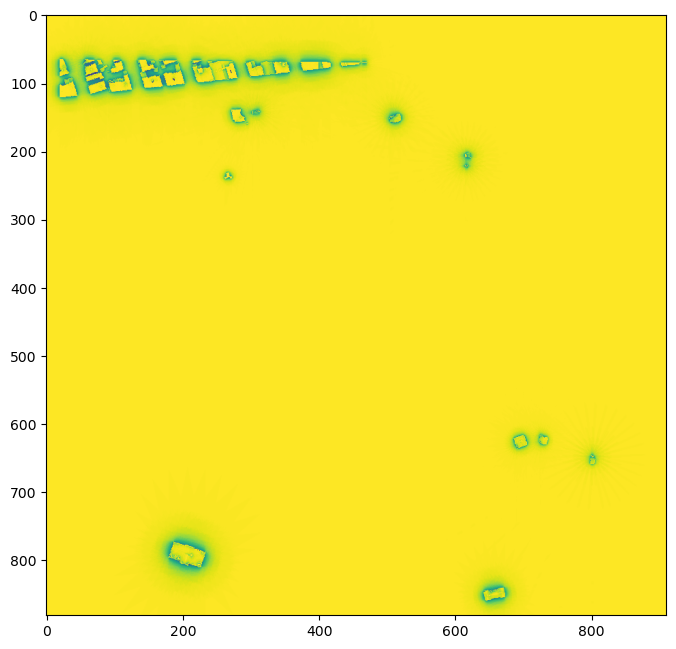

In [12]:
plt.imshow(svfres)
#saverasternd(gdal_dsm, 'B_0.tif', svfres)
#plt.savefig('svf.png', dpi=300)